# Generate RID realizations

In [6]:
import os
os.chdir('../../')

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src import models

### Parameters
- num_stripes: Number of input files, one for each stripe (i.e., hazard level)
- combine_directions: Combine all directions of each story
- num_realizations: Number of realizations for data sampling

In [8]:
num_stripes = 8
combine_directions = True
num_realizations = 10000

### Main code

In [10]:
# load data
edp_data = []
for i in range(num_stripes):
    data = pd.read_csv(f'src/notebooks/example_input/edps_stripe_{i+1}.csv', index_col=0, header=[0, 1, 2])
    edp_data.append(data)

# combine data
edp_df = pd.concat(edp_data, keys=range(1, num_stripes + 1), axis=0)
edp_df.index.names = ('stripe', 'run')
if combine_directions:
    edp_df = edp_df.stack('dir')

# determine story tags
stories = edp_df.columns.get_level_values('loc').unique()

# fit models
model_dict = {}
for story in stories:
    if combine_directions:
        analysis_rids = edp_df['RID'][story]
        analysis_pids = edp_df['PID'][story]
        model = models.Model_1_Weibull()
        model.censoring_limit = 0.0005
        model.add_data(analysis_pids.values, analysis_rids.values)
        model.fit(method='quantiles')
        model_dict[story] = model
    else:
        for direction in edp_df['RID'][story].columns:
            analysis_rids = edp_df['RID'][story][direction]
            analysis_pids = edp_df['PID'][story][direction]
            model = models.Model_1_Weibull()
            model.censoring_limit = 0.0005
            model.add_data(analysis_pids.values, analysis_rids.values)
            model.fit(method='quantiles')
            model_dict[(story, direction)] = model


# simulate data for each stripe
simulated_data_dict = {}


def add_sample(index, stripe):
    model = model_dict[index]
    analysis_pids = model.raw_pid
    sampled_pids = np.random.choice(analysis_pids, num_realizations, replace=True)
    sampled_rids = model.generate_rid_samples(sampled_pids)
    simulated_data_dict[(*index, stripe)] = (sampled_pids, sampled_rids)


for i in range(num_stripes):
    for story in stories:
        if combine_directions:
            add_sample(story, i + 1)
        else:
            for direction in edp_df['RID'][story].columns:
                add_sample((story, direction), i + 1)

pid_df = pd.DataFrame(
    [x[0] for x in simulated_data_dict.values()], index=simulated_data_dict.keys()
).T
rid_df = pd.DataFrame(
    [x[0] for x in simulated_data_dict.values()], index=simulated_data_dict.keys()
).T
simulated_data_df = pd.concat((pid_df, rid_df), keys=('PID', 'RID'), axis=1)
if combine_directions:
    simulated_data_df.columns.names = ('edp', 'stripe', 'loc')
else:
    simulated_data_df.columns.names = ('edp', 'stripe', 'loc', 'dir')

if not os.path.exists('output/'):
    os.makedirs('output/')

simulated_data_df.to_csv('output/simulated_data.csv')



### Visualization Code

##### Parameters

In [16]:
story = '3'
stripe = '6'  # used for the CDF curves
direction = '1'  # ignored when `combine_directions=True`

xlim = (0.00, 0.04)
ylim = (0.00, 0.08)

##### Main plotting code

/tmp/ipykernel_86304/379456501.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x*100.00:.1f}%' for x in ax.get_xticks().tolist()])
/tmp/ipykernel_86304/379456501.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*100.00:.1f}%' for x in ax.get_yticks().tolist()])
/home/john_vm/micromamba/envs/rid_prj/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


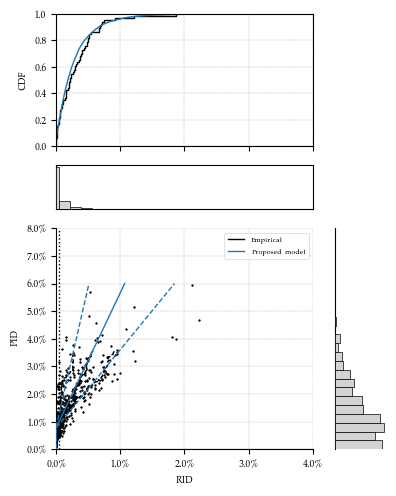

In [15]:

fig, axs = plt.subplots(
    3,
    2,
    figsize=(4.00, 5.0),
    gridspec_kw={'width_ratios': [5, 1], 'height_ratios': [3, 1, 5]},
)

# main plot
ax = axs[2, 0]

if combine_directions:
    ax.scatter(
        edp_df['RID'][story],
        edp_df['PID'][story],
        color='black',
        marker='.',
        s=5,
    )
else:
    ax.scatter(
        edp_df['RID'][story][direction],
        edp_df['PID'][story][direction],
        color='black',
        marker='.',
        s=5,
    )

if combine_directions:
    model = model_dict[story]
else:
    model = model_dict[(story, direction)]
model.calculate_rolling_quantiles()

ax.plot(model.rolling_rid_50, model.rolling_pid, 'k', label='Empirical')
ax.plot(model.rolling_rid_20, model.rolling_pid, 'k', linestyle='dashed')
ax.plot(model.rolling_rid_80, model.rolling_pid, 'k', linestyle='dashed')

model_pid = np.linspace(0.00, 0.06, 1000)
model_rid_50 = model.evaluate_inverse_cdf(0.50, model_pid)
model_rid_20 = model.evaluate_inverse_cdf(0.20, model_pid)
model_rid_80 = model.evaluate_inverse_cdf(0.80, model_pid)

ax.plot(model_rid_50, model_pid, 'C0', label='Proposed model', zorder=10)
ax.plot(model_rid_20, model_pid, 'C0', linestyle='dashed', zorder=10)
ax.plot(model_rid_80, model_pid, 'C0', linestyle='dashed', zorder=10)

ax.legend(fontsize='6')


ax.axvline(x=model.censoring_limit, color='black', linestyle='dotted')

ax.set(xlim=xlim, ylim=ylim, xlabel='RID', ylabel='PID')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# transform axis labels
ax.set_xticklabels([f'{x*100.00:.1f}%' for x in ax.get_xticks().tolist()])
ax.set_yticklabels([f'{x*100.00:.1f}%' for x in ax.get_yticks().tolist()])
ax.grid(which='both', linestyle='dashed', linewidth=0.30)

# histogram of PIDs
ax = axs[2, 1]

ax.hist(
    model.raw_pid,
    bins=25,
    orientation='horizontal',
    density=True,
    edgecolor='black',
    facecolor='lightgrey',
    zorder=10,
    range=(0, ylim[1]),
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# remove axis labels
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set(ylim=ylim)
ax.grid(which='both', linestyle='dashed', linewidth=0.30, zorder=-100)

# histogram of RIDs
ax = axs[1, 0]

bins = np.concatenate(
    (
        np.array((0.00, model.censoring_limit)),
        np.linspace(model.censoring_limit, xlim[1], 24),
    )
)

ax.hist(
    model.raw_rid,
    bins=bins,
    density=True,
    edgecolor='black',
    facecolor='lightgrey',
    zorder=10,
    range=(0, xlim[1]),
)
# remove axis labels
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set(xlim=xlim)
ax.grid(which='both', linestyle='dashed', linewidth=0.30, zorder=-100)

# ecdf plot
ax = axs[0, 0]

if combine_directions:
    vals = np.random.choice(
        edp_df.loc[int(stripe), 'PID'][story].values, size=10000, replace=True
    )
else:
    vals = np.random.choice(
        edp_df.loc[int(stripe), 'PID'][story][direction].values,
        size=10000,
        replace=True,
    )
model.generate_rid_samples(vals)

if combine_directions:
    sns.ecdfplot(
        edp_df.loc[int(stripe), 'RID'][story].values,
        ax=ax,
        label='Empirical',
        color='black',
    )
else:
    sns.ecdfplot(
        edp_df.loc[int(stripe), 'RID'][story][direction].values,
        ax=ax,
        label='Empirical',
        color='black',
    )
sns.ecdfplot(model.sim_rid, ax=ax, label='Proposed model', color='C0')
ax.set(xlim=xlim, ylabel='CDF', xlabel=None)
ax.grid(which='both', linestyle='dashed', linewidth=0.30)
ax.set_xticklabels([])

# remove other axs
fig.delaxes(axs[0, 1])
fig.delaxes(axs[1, 1])

fig.tight_layout()
plt.show()
